# Depth correction from 120-mer nanocage data



In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
from skimage.filters.thresholding import threshold_otsu

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import flymovie as fm

# Activate package autoload.
%load_ext autoreload
%autoreload 2


## Process 120mer stacks



In [40]:
# Read file.
czi_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/quantitation/20210524-120mer-deepstack-em2-2p0pct-01.czi'

stack, first_dist, z_interval = fm.load_save.read_czi(czi_filename, swapaxes=True, trim=True, return_metadata=True)
fm.viewer(stack, 6)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'Reds', 'viridis', 'cividis', …

In [42]:
# Perform DoG filtering.
channel=0
sigma_big = 4
sigma_small = 0

# Normalize Z slices and make stacks.
stack3d = stack[channel, 0]
stack4d = np.expand_dims(stack3d, axis=0)
stack5d = np.expand_dims(stack4d, axis=0)

dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])

In [44]:
# Pick a slice near the middle and determine a reasonable threshold for it.
ref_slice = 30
ref_thresh = 3500
test_im = ndi.morphology.binary_opening(np.where(stack3d[ref_slice] >= ref_thresh, 1, 0), structure=np.ones((2,2)))
fm.viewer(np.where(test_im, 1, 0))

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'Reds', 'viridis', 'cividis', …

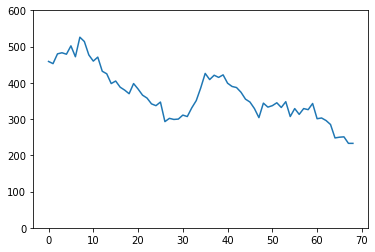

In [46]:
# Test different threshold slopes to get fairly object detection through Z.
mask = fm.threshold_w_slope(dog, ref_thresh, 30, -25, display=True)

In [47]:
# Check out mask and make sure it looks reasonable.
fm.viewer(mask,8)

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'Reds', 'viridis', 'cividis', …

In [48]:
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fm.fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3, sample_size=8000)
fm.quickview_ms2(stack5d, fits, MAX=False, shadows=False, halfwidth_z=0)

0
# to fit: 8000
# fit:  1000 2000 3000 4000 5000 6000 7000 8000 

interactive(children=(Dropdown(description='Color', index=3, options=('Greens', 'Reds', 'viridis', 'cividis', …

In [51]:
# Filter spots based on fit parameters, get spot-centered stacks, organized by z slice.
peakiness = 7
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
spots_byz = fm.spotstacks_fromfits_byz(stack4d, fits_filtered)

In [52]:
# Save results.
fm.save_pickle([spots_byz.copy(), fits, first_dist, z_interval],'/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210524-120mer-deepstack-em2-2p0pct-03.pkl')
print(first_dist)

## Compute depth correction

In [2]:
folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/'

spots_em1_0p5, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em1-0p5pct-03.pkl'))
spots_em1_1p0, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em1-1p0pct-03.pkl'))
spots_em1_1p5, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em1-1p5pct-03.pkl'))
spots_em1_2p0, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em1-2p0pct-03.pkl'))
spots_em2_0p5, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em2-0p5pct-03.pkl'))
spots_em2_1p0, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em2-1p0pct-03.pkl'))
spots_em2_1p5, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em2-1p5pct-03.pkl'))
spots_em2_2p0, _, _, _ = fm.load_pickle(os.path.join(folder, '20210524-120mer-deepstack-em2-2p0pct-03.pkl'))

In [3]:
# Set datasets, embryo surface positions, stack start positions, and z-slice interval (in µm).
datasets = [spots_em1_0p5, spots_em1_1p0, spots_em1_1p5, spots_em1_2p0, spots_em2_0p5, spots_em2_1p0, spots_em2_1p5, spots_em2_2p0]
surface = [-626, -625.62, -625.62, -624.48, -631.92, -631.92, -633.05, -632.64]
starts = [-623.7, -623.7, -623.7, -618.9, -628, -628, -628, -628]

interval = float(0.23)

In [56]:
datasets = [spots_em1_0p5, spots_em1_1p0, spots_em1_1p5, spots_em1_2p0]
surface = [-626, -625.62, -625.62, -624.48, -631.92, -631.92, -633.05, -632.64]
starts = [-623.7, -623.7, -623.7, -618.9, -628, -628, -628, -628]

interval = float(0.23)

In [4]:
# Make vectors of absolute depths and mean spot intensity.
depths, intensities = fm.make_depth_vs_intensity_vectors(datasets, surface, starts, interval, 
        return_mean=True, min_spots_for_mean=10, mode='mean_intensity', inner_length_ij=3)

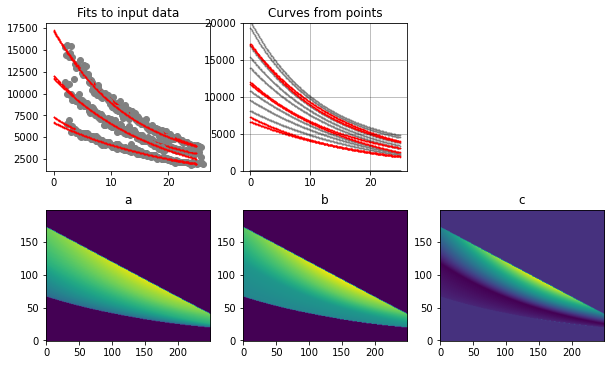

In [9]:
good_datasets = [0,1,2,4,5,6]
xgrid_start = 0
xgrid_end = 25
xgrid_incr = 0.1
ygrid_start = 0
ygrid_end = 20000
ygrid_incr = 100

depths_good = [depths[n] for n in good_datasets]
intensities_good = [intensities[n] for n in good_datasets]
paramgrid_a, paramgrid_b, paramgrid_c = fm.fit_interpolate_depth_curves(depths_good, intensities_good, xgrid_start, 
    xgrid_end, xgrid_incr, ygrid_start, ygrid_end, ygrid_incr, display=True)                              

In [368]:
fm.save_pickle((paramgrid_a, paramgrid_b, paramgrid_c), '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210613-depth-correction-params.pkl')